In [2]:
pip install category_encoders

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [5]:
!pip install scikit-optimize

# Data Preprocessing

In [6]:
import pandas as pd

df = pd.read_csv("/content/car_prices.csv")

In [7]:
df.isnull().sum()

,0
year,0
make,254
model,256
trim,454
body,1863
transmission,7303
vin,0
state,0
condition,11793
odometer,76


In [8]:
df['transmission'].fillna('automatic', inplace=True)

In [9]:
df = df.dropna(subset=['vin', 'state','sellingprice','saledate','make', 'model', 'trim','body','condition','odometer','color','interior','mmr'])

In [10]:
# Select categorical columns
categorical_columns = ['make','model','trim','body','transmission','vin','state','color','interior','seller','saledate']

In [11]:
from category_encoders import TargetEncoder
# Create a copy of the dataframe
df_encoded = df.copy()

# Apply Target Encoding
encoder = TargetEncoder(cols=categorical_columns)
df_encoded[categorical_columns] = encoder.fit_transform(df[categorical_columns], df['mmr'])


In [12]:
# Compute the correlation matrix
correlation_matrix = df_encoded.corr(method='pearson')

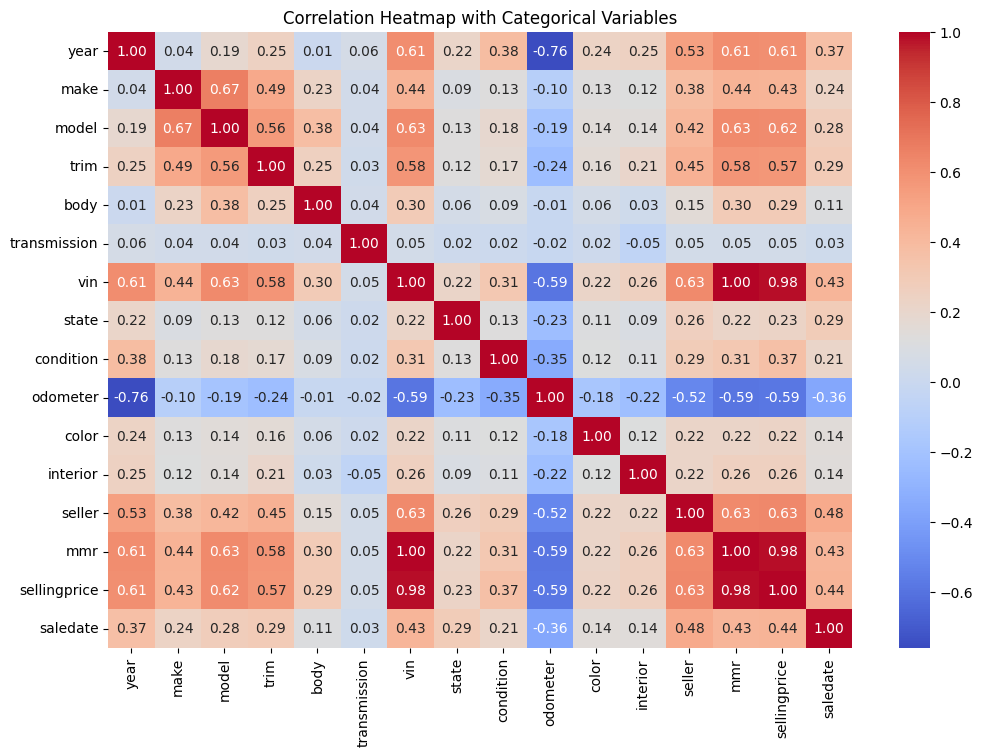

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap with Categorical Variables")
plt.show()


In [14]:
#list and drop columns that are less related to the target based on my judgement
cols_to_drop = ['transmission','color','vin','interior','state','sellingprice','saledate']

#at the same time rename the columns so they are understandable.
df = df.drop(columns = cols_to_drop).rename(columns = {'year':'manufacture_year','make':'brand','model':'specific_model',
                                                      'trim':'additional_designation','mmr':'estimated_value'})


In [27]:
catego_attr = ['brand', 'specific_model',	'additional_designation',	'body',	'condition',	'odometer',	'seller' ]

In [28]:
# Convert Categorical values in to numerical values
df[catego_attr] = df[catego_attr].apply(lambda x: x.astype('category').cat.codes)

In [29]:
df.head()

,manufacture_year,brand,specific_model,additional_designation,body,condition,odometer,seller,estimated_value
0,2015,19,516,563,32,4,3957,1951,20500.0
1,2015,19,516,563,32,4,1422,1951,20800.0
2,2014,2,6,180,33,36,110,1355,31900.0
3,2015,42,466,830,33,32,3029,3756,27500.0
5,2015,29,42,74,33,0,579,1257,15350.0


In [30]:
num_duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {num_duplicates}')

Number of duplicate rows: 0


In [31]:
df.drop_duplicates(inplace=True)

In [32]:
Q1 = df['estimated_value'].quantile(0.25)
Q3 = df['estimated_value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['estimated_value'] < lower_bound) | (df['estimated_value'] > upper_bound)]

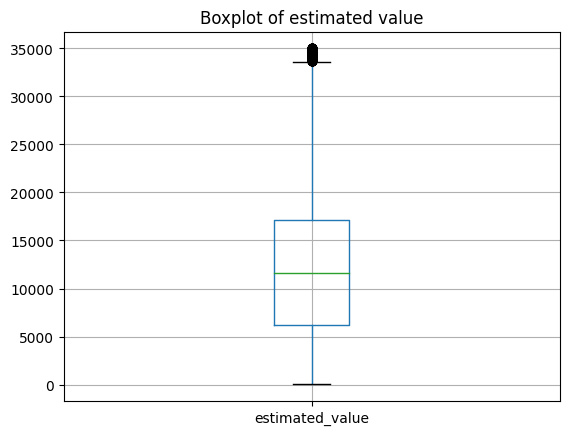

In [33]:
df[['estimated_value']].boxplot()
plt.title('Boxplot of estimated value')
plt.show()

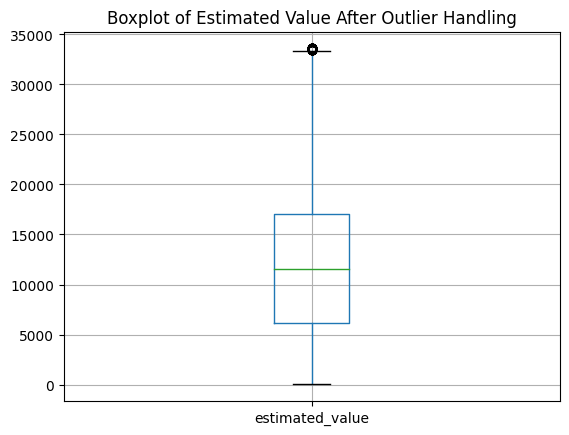

In [54]:
df = df[(df['estimated_value'] >= lower_bound) & (df['estimated_value'] <= upper_bound)]

df[['estimated_value']].boxplot()
plt.title('Boxplot of Estimated Value After Outlier Handling')
plt.show()

In [35]:
#Split to training and testing

from sklearn.model_selection import train_test_split

x = df.drop(columns = 'estimated_value')
y = df['estimated_value']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2,random_state=8)

In [36]:
print(x)

       manufacture_year  brand  specific_model  additional_designation  body  \
0                  2015     19             516                     563    32   
1                  2015     19             516                     563    32   
2                  2014      2               6                     180    33   
3                  2015     42             466                     830    33   
5                  2015     29              42                      74    33   
...                 ...    ...             ...                     ...   ...   
59992              2000     17             460                     196    33   
59993              2000     10             495                     744    31   
59994              2000     13              37                     396     9   
59995              2000     13              37                     391    33   
59996              2000     14             170                     454    33   

       condition  odometer  seller  
0 

In [37]:
print(y)

0        20500.0
1        20800.0
2        31900.0
3        27500.0
5        15350.0
          ...   
59992     1350.0
59993     1025.0
59994     1225.0
59995     1950.0
59996      675.0
Name: estimated_value, Length: 45324, dtype: float64


Model Training : Random Forest Regressor

In [38]:
regressor = RandomForestRegressor(n_estimators = 100 )

In [39]:
# Training the model
regressor.fit(X_train, Y_train)

RandomForestRegressor()

Model Evaluation

In [40]:
# Prediction on Test data
test_data_prediction = regressor.predict(X_test)

In [41]:
print(test_data_prediction)

[ 7264.  17249.  12706.5 ...  5298.5 19235.5 24359.5]


In [49]:
# R squared error
error_score = r2_score(Y_test, test_data_prediction)
print("R squared error : ", error_score)

R squared error :  0.9476672615233305


In [51]:
# Calculate Mean Absolute Error
mae = mean_absolute_error(Y_test, test_data_prediction)
print(f'Mean Absolute Error for training data: {mae}')

Mean Absolute Error for training data: 982.2298896856039


Compare the Actual Values and Predicted Values in a plot

In [52]:
Y_test = list(Y_test)

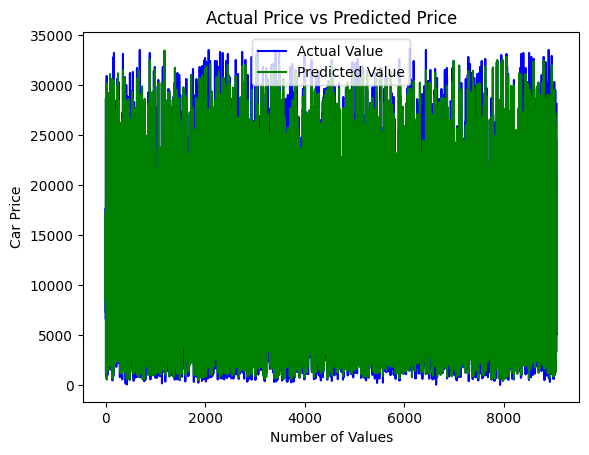

In [53]:
plt.plot(Y_test, color = 'blue', label = 'Actual Value')
plt.plot(test_data_prediction, color = 'green', label = 'Predicted Value')
plt.title("Actual Price vs Predicted Price")
plt.xlabel('Number of Values')
plt.ylabel('Car Price')
plt.legend()
plt.show()